Let's go.

In [54]:
import pandas as pd

In [55]:
def openData():
    df=pd.read_csv("../data2.csv")
    df.drop_duplicates()
    return df
df=openData()

df=df.dropna(subset=['price'])
df.drop('rooms',axis=1,inplace=True)
df.drop('floor',axis=1,inplace=True)
df['price']/=1e9
df['averageDistrictValue']/=1e6
df['test']/=1e9

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5877 entries, 0 to 5876
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   meter                 5877 non-null   int64  
 1   district              5877 non-null   object 
 2   buildYear             5877 non-null   int64  
 3   price                 5877 non-null   float64
 4   elevator              5877 non-null   int64  
 5   space                 5877 non-null   int64  
 6   parking               5877 non-null   int64  
 7   averageDistrictValue  5877 non-null   float64
 8   test                  5877 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 413.4+ KB


just working a bit with the dataset to understand what's going on. you can pass this.

In [56]:
print(df.describe())

              meter     buildYear        price     elevator        space  \
count   5877.000000   5877.000000  5877.000000  5877.000000  5877.000000   
mean     109.091543   1394.118598    10.778156     0.738302     0.770631   
std     1219.402183    163.403255    12.077508     0.439597     0.420463   
min       20.000000   1370.000000     2.014000     0.000000     0.000000   
25%       60.000000   1385.000000     3.550000     0.000000     1.000000   
50%       80.000000   1393.000000     6.305000     1.000000     1.000000   
75%      114.000000   1400.000000    13.000000     1.000000     1.000000   
max    93500.000000  13902.000000    98.000000     1.000000     1.000000   

           parking  averageDistrictValue          test  
count  5877.000000           5877.000000   5877.000000  
mean      0.860303             97.753168     12.816280  
std       0.346702             46.816751    168.008494  
min       0.000000             34.607752      1.077060  
25%       1.000000            

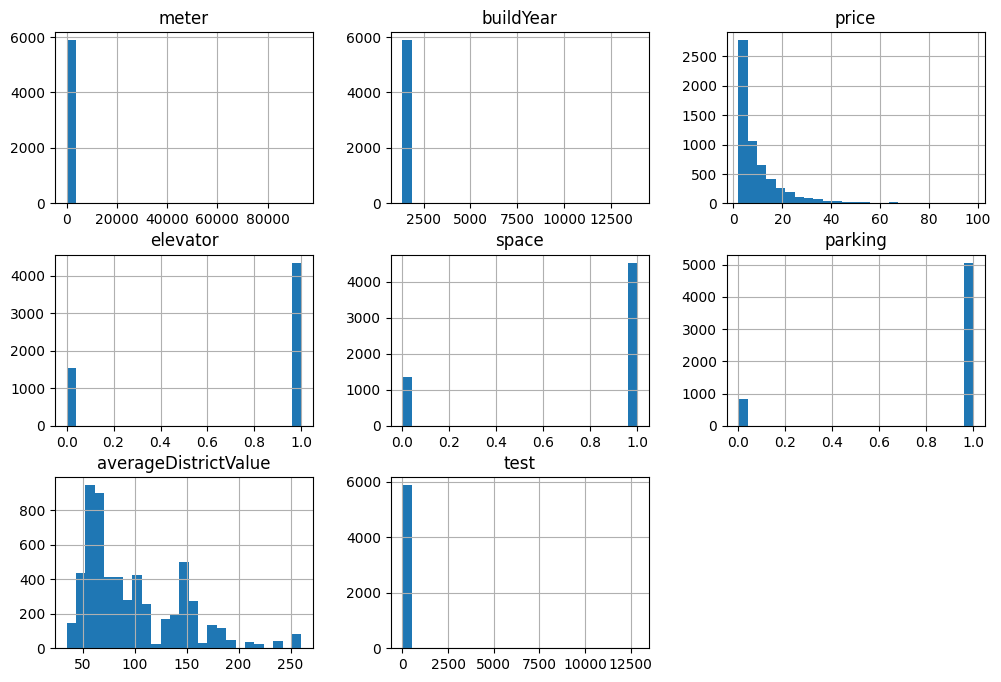

In [57]:
import matplotlib.pyplot as plt
df.hist(bins=25, figsize=(12, 8))
plt.show()

**Deleting the outliers**

In [58]:
import numpy as np
from scipy import stats
outlierHigh = df["price"].quantile(0.98)
outlierLow = df["price"].quantile(0.02)
df.reset_index()
df=df[(df['price'] > 2) & (df['price'] < 100)]
df=df[(df['meter'] > 35) & (df['meter'] < 2000)]
df=df[(df['buildYear'] > 1355) & (df['buildYear'] < 1404)]
df=df[(df['district'].str.contains("[^chitgar]"))] # never learned regex :P
df=df[(df['district'].str.contains("[lake]"))] # never learned regex :P


print(outlierLow,outlierHigh)
df.describe()

2.2 50.0


,meter,buildYear,price,elevator,space,parking,averageDistrictValue,test
count,5797.000000,5797.000000,5797.000000,5797.000000,5797.000000,5797.000000,5797.000000,5797.000000
mean,93.620838,1392.021563,10.847912,0.742453,0.772641,0.860790,97.992900,10.707619
std,48.635261,8.430022,12.129903,0.437321,0.419162,0.346195,47.030498,11.148906
min,36.000000,1370.000000,2.014000,0.000000,0.000000,0.000000,34.607752,1.652185
25%,60.000000,1385.000000,3.575000,0.000000,1.000000,1.000000,60.772401,3.796942
50%,80.000000,1393.000000,6.400000,1.000000,1.000000,1.000000,83.873621,6.396345
75%,115.000000,1400.000000,13.000000,1.000000,1.000000,1.000000,135.086320,13.351999
max,600.000000,1403.000000,98.000000,1.000000,1.000000,1.000000,260.472461,102.599056


**making the test set**

In [59]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [60]:
house_with_id = df.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

count    5797.000000
mean       10.847912
std        12.129903
min         2.014000
25%         3.575000
50%         6.400000
75%        13.000000
max        98.000000
Name: price, dtype: float64


Text(0, 0.5, 'Number of districts')

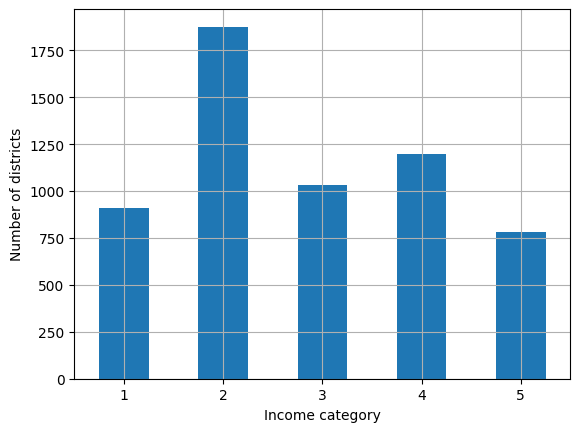

In [61]:
print(df['price'].describe())
df["cat"] = pd.cut(df["price"].astype(float),
bins=[0., 3, 6, 10, 20, np.inf],
labels=[1, 2, 3, 4, 5])
df["cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(df, df["cat"]):
    stratTrainSetN = df.iloc[trainIndex]
    stratTestSetN = df.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]
g=0
with open("errors.txt",'w') as file:
    for i in range(len(df['price'].values)):
        elem=df.iloc[i]
        realPrice=df['price'].values[i]
        error=abs(realPrice-elem['test'])
        if(error>min(elem['test'],realPrice)*2):

            file.write(f"{elem}\n\n")
            g+=1
print(g)

16


In [63]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("cat", axis=1 , inplace=True)

/tmp/ipykernel_46741/1832761340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("cat", axis=1 , inplace=True)
/tmp/ipykernel_46741/1832761340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [64]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price                   1.000000
test                    0.951288
meter                   0.865543
averageDistrictValue    0.785638
space                   0.306414
elevator                0.295957
parking                 0.198821
buildYear               0.172812
Name: price, dtype: float64


/tmp/ipykernel_46741/3448244544.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = house.corr()


_note 1_ : wow it seems that meter is really important!

In [65]:
house = stratTrainSet.drop('price',axis=1)
labels = stratTrainSet[['price']].copy()

**And finally The PIPELINE**

In [66]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
houseNum=house.select_dtypes(np.number)

num_pipeline = Pipeline([
("impute", SimpleImputer(strategy='most_frequent')),
("normal",StandardScaler())
])
houseNumPrepared=num_pipeline.fit_transform(houseNum)
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown='ignore')
)

preprocessing = ColumnTransformer([("cats",cat_pipeline,['district'])],remainder=num_pipeline)
preprocessing.fit(house)
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                             SimpleImputer(strategy='most_frequent')),
                                            ('normal', StandardScaler())]),
                  transformers=[('cats',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['district'])])

**Train**

**Really, Really Testing for overfitting**

In [67]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=4))
print(sklearn.metrics.get_scorer_names())
forest_mae = -cross_val_score(forest_reg, house, labels['price'],cv=7,scoring="neg_mean_absolute_error")

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [68]:

print(forest_mae.mean(),forest_mae.std())
print(type(labels['price']))
forest_reg.fit(house,labels['price'])
housing_predictions = forest_reg.predict(house)

X_test = stratTestSet.drop("price", axis=1)
y_test = stratTestSet[["price"]].copy()

final_predictions = forest_reg.predict(X_test)
a=[[],[]]
b=[[],[]]
dis={}

for i in range(len(y_test)):
    realPrice=y_test.values[i]
    error=abs(realPrice-final_predictions[i])
    if(error>min(final_predictions[i],realPrice)*0.5):
        b[0].append(error)
        b[1].append(realPrice)
        elem=stratTestSet.iloc[i]
        if(error>5 and realPrice<5):
            print(elem,final_predictions[i])
        if(elem['district'] in dis): 
            dis[elem['district']]+=1
        else: 
            dis[elem['district']]=1
    else:
        a[0].append(error)
        a[1].append(realPrice)
print( {k: v for k, v in sorted(dis.items(), key=lambda item: item[1],reverse=True)})
plt.scatter(a[1],a[0],alpha=0.2)
print(len(b[1]),len(b[0]))
plt.scatter(b[1],b[0],color='red')
plt.xlabel("price")
plt.ylabel("error")
plt.show()

1.3584686950328742 0.05576738900892196
<class 'pandas.core.series.Series'>


**Fine tune

In [ ]:
from sklearn.model_selection import GridSearchCV
full_pipeline = Pipeline([
("preprocessing", preprocessing),
("random_forest", RandomForestRegressor(random_state=4)),
])
param_grid = [
{'random_forest__max_features': [4],
'random_forest__n_estimators':[100],
'random_forest__max_depth':[20],
'random_forest__min_samples_leaf':[1],
}
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
scoring='neg_mean_absolute_error')
grid_search.fit(house,labels.values.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                    ('normal',
                                                                                     StandardScaler())]),
                                                          transformers=[('cats',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['district'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=4))]),
             param_grid=[{'random_forest__max_depth': [20],
                          'random_forest__max_features': [4],
                          'random_forest__min_samples_leaf': [1],
                          'random_forest__n_estimators': [100]}],
             scoring='neg_mean_absolute_error')

In [ ]:
print(grid_search.best_params_)
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()


{'random_forest__max_depth': 20, 'random_forest__max_features': 4, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__min_samples_leaf,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.868731,0.038493,0.055281,0.002384,20,4,1,100,"{'random_forest__max_depth': 20, 'random_fores...",-2.96104,-2.894818,-2.858683,-2.904847,0.042385,1
